In [1]:
%matplotlib inline
import numpy as np                                                                                                 
import matplotlib.pyplot as plt                                                                                    
import pandas as pd

import bc_utils as butils

from scipy.spatial import distance
from mpl_toolkits import mplot3d

from sklearn.model_selection import train_test_split                                                               
from sklearn.preprocessing import StandardScaler                                                                   
from sklearn.neighbors import KNeighborsClassifier 

# 1. Load data

In [48]:
# Read dataset to pandas dataframe
# current datasets ready for testing:
#   blobs.csv
#   blobs_3d.csv
#   iris.csv
#   noisy_circles.csv
#   noisy_circles_3d.csv
#   overlap.csv

df = pd.read_csv("overlap.csv", index_col=0)
df

,x,y,z,cluster
0,115,268,129,0
1,409,112,328,0
2,475,452,88,0
3,416,346,311,0
4,97,272,302,0
5,246,232,469,0
6,212,352,445,0
7,176,346,70,0
8,101,495,494,0
9,383,295,388,0


# 2. Plot data

Visualize data if they have 2 or 3 features.

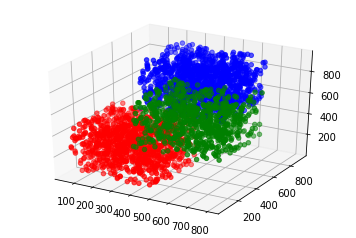

In [53]:
colors = {0:'red', 1:'blue', 2:'green'}

if (df.columns.size == 3):
    fix, ax = plt.subplots()
    grouped = df.groupby('cluster')
    
    i = 0
    for group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y',
                   label=key, color=colors[i])
        i = i + 1
    plt.show()
elif (df.columns.size == 4):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    grouped = df.groupby('cluster')

    i = 0
    for key, group in grouped:
        ax.scatter(group['x'], group['y'], group['z'], color=colors[i])
        i = i + 1
    plt.show()
else:
    print("There is no good visualisation for this dataset - " + str(df.columns.size) + " features.")
    

In [54]:
#creating test datasets for iris
names = set(df['cluster'])

dataframes = {}
for name in names:
    tmp_df = df[df['cluster'] == name]
    dataframes[name] = butils.TestDf(tmp_df)
    
full_test_df = pd.DataFrame()
for name in names:
    full_test_df = full_test_df.append(dataframes[name].test_df)

In [55]:
#using delta_medoids_full algorithm
results = {}
for name in names:
    delta_df = dataframes[name].train_df.iloc[:, :-1]

    result = butils.delta_medoids_full(delta_df, butils.estimate_delta(delta_df, distance.euclidean), distance.euclidean)
    result['cluster'] = name
    results[name] = result
    
print(results)

delta_medoids_full algorithm ended after 5 iterations.
delta_medoids_full algorithm ended after 6 iterations.
delta_medoids_full algorithm ended after 5 iterations.
{0:       x    y    z  cluster
0   425  162  496        0
1    75  144  269        0
2   416  346  311        0
3   264  450  417        0
4   265   92   95        0
5    77  377   97        0
6   442  129  134        0
7   132  108  100        0
8   248  336  315        0
9   376  260  118        0
10  126  268  132        0
11   69  184  451        0
12  401  323  446        0
13  243  302  114        0
14  452  423  130        0
15  409  112  328        0
16  177  436  127        0
17  248  273  438        0
18  100  295  304        0
19  212  148  214        0
20  209   98  397        0
21  114  435  470        0
22  195  482  291        0
23  407  414  378        0, 3:       x    y    z  cluster
0   282  535  514        3
1   352  770  896        3
2   328  759  574        3
3   517  850  889        3
4   323  859  875

In [56]:
#using delta_medoids_one_shot algorithm
results2 = {}
for name in names:
    delta_df = dataframes[name].train_df.iloc[:, :-1]

    result = butils.delta_medoids_one_shot(delta_df, butils.estimate_delta(delta_df, distance.euclidean), distance.euclidean)
    result['cluster'] = name
    results2[name] = result
    
print(results2)

{0:       x    y    z  cluster
0   115  268  129        0
1   409  112  328        0
2   475  452   88        0
3   416  346  311        0
4    97  272  302        0
5   246  232  469        0
6   101  495  494        0
7   212  148  214        0
8    69  184  451        0
9   418  279   74        0
10  248  336  315        0
11  263  301   67        0
12  196  463  110        0
13  425  162  496        0
14  489  164  181        0
15   55   89  226        0
16  429  478  395        0
17  197  491  264        0
18   51  390   53        0
19  209   98  397        0
20  283   55  102        0
21  280  468  456        0
22  393  320  493        0
23   88   91   50        0, 3:       x    y    z  cluster
0   605  798  583        3
1   541  735  733        3
2   486  629  883        3
3   644  586  626        3
4   317  898  633        3
5   319  884  888        3
6   264  628  828        3
7   320  761  552        3
8   365  590  564        3
9   641  542  839        3
10  219  557  639   

In [57]:
#creating training DataFrames for comparing oneshot and full delta medoids algorithm
train_delta_medoids_full = pd.DataFrame()
train_delta_medoids_one_shot = pd.DataFrame()

for name in names:
    train_delta_medoids_full = train_delta_medoids_full.append(results[name])
    train_delta_medoids_one_shot = train_delta_medoids_one_shot.append(results2[name])


In [58]:
def classifyPoints(ref_df, test_df):

    X_train = ref_df.iloc[:, :-1].values
    y_train = ref_df.iloc[:, -1].values
    X_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values

    from sklearn.preprocessing import StandardScaler  
    scaler = StandardScaler()  
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)  
    X_test = scaler.transform(X_test)

    from sklearn.neighbors import KNeighborsClassifier  
    classifier = KNeighborsClassifier(n_neighbors=5)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    from sklearn.metrics import classification_report, confusion_matrix  
    print(confusion_matrix(y_test, y_pred))  
    print(classification_report(y_test, y_pred))

In [61]:
classifyPoints(train_delta_medoids_full, full_test_df)

[[190   0  10]
 [  4 234   2]
 [ 12  13 135]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       200
           3       0.95      0.97      0.96       240
           5       0.92      0.84      0.88       160

   micro avg       0.93      0.93      0.93       600
   macro avg       0.93      0.92      0.93       600
weighted avg       0.93      0.93      0.93       600



In [62]:
classifyPoints(train_delta_medoids_one_shot, full_test_df)

[[189   1  10]
 [  3 234   3]
 [ 16  17 127]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       200
           3       0.93      0.97      0.95       240
           5       0.91      0.79      0.85       160

   micro avg       0.92      0.92      0.92       600
   macro avg       0.91      0.90      0.91       600
weighted avg       0.92      0.92      0.92       600

